<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/cnn2%20(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow_addons

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:


# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
#x_train = (x_train.astype("float32") - 127.5) / 127.5
#y_train = y_train.reshape(-1, 1)
x_train = (x_train.astype("float32")) / np.max(x_train)

New dataset shape: (100, 28, 28)


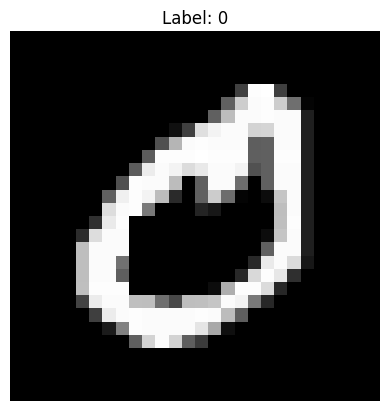

In [4]:
new_images = []
new_labels = []

for digit in set(y_train):
    digit_indices = np.where(y_train == digit)[0][:10]
    for index in digit_indices:
        image = x_train[index]
        label = y_train[index]
        new_images.append(image)
        new_labels.append(label)

new_images = np.array(new_images)
new_labels = np.array(new_labels)

print("New dataset shape:", new_images.shape)

# Visualize the new dataset
plt.imshow(new_images[1], cmap="gray")
plt.title("Label: {}".format(new_labels[1]))
plt.axis("off")
plt.show()

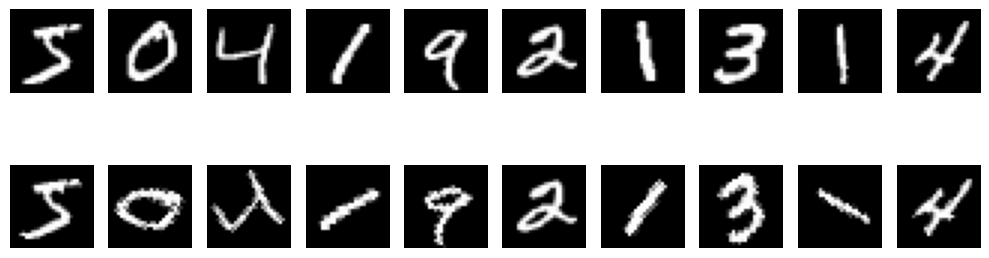

In [5]:
def random_rotate_images(images, min_angle=-90):
    size = tf.shape(images)[0]
    random_angles = tf.random.uniform(shape=(size,), minval=min_angle, maxval=-min_angle, dtype=tf.float32)
    rotated_images = tfa.image.rotate(images, random_angles / 90)
    return rotated_images

# Select a batch of images
batch_size = 10
batch_images = x_train[:batch_size]
batch_images = np.expand_dims(batch_images, axis=-1)
rotated_images = random_rotate_images(batch_images)

fig, axes = plt.subplots(nrows=2, ncols=batch_size, figsize=(10, 4))
for i in range(batch_size):
    axes[0][i].imshow(batch_images[i], cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(rotated_images[i], cmap='gray')
    axes[1][i].axis('off')
plt.tight_layout()
plt.show()


In [6]:
def build_generator():
    noise_shape = (100,)
    noise = layers.Input(shape=noise_shape)
    input_digit = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 10)(input_digit)
    digit_embedding = layers.Flatten()(digit_embedding)

    x = layers.Concatenate()([noise, digit_embedding])

    # Transform the concatenated vector into a 7x7x256 tensor
    x = layers.Dense(7 * 7, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 1))(x)

    # Upsample to 14x14
    x = layers.Conv2DTranspose(24, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Conv 14x14
    x = layers.Conv2D(24, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Upsample to 28x28
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final output layer
    output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='hard_sigmoid')(x)

    model = tf.keras.models.Model(inputs=[noise, input_digit], outputs=output)
    return model

generator = build_generator()
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        100         ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 10)           0           ['embedding[0][0]']              
                                                                                              

In [7]:
def build_discriminator():
    input_image = layers.Input(shape=(28, 28, 1))
    digit_input = layers.Input(shape=(1,), dtype="int32")
    digit_embedding_2d = layers.Embedding(10, 10)(digit_input)
    digit_embedding_2d = layers.Flatten()(digit_embedding_2d)
    #digit_embedding_2d = layers.Reshape((28, 28, 1))(digit_embedding_2d)

    #merged_input = layers.Concatenate()([input_image, digit_embedding_2d])

    # Convolutional layers
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_image)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(248, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Concatenate()([x,digit_embedding_2d])
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(300, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.models.Model(inputs=[input_image, digit_input], outputs=x)
    return model

discriminator = build_discriminator()
#discriminator.summary()


In [8]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0004)
copy_optimizer = tf.keras.optimizers.legacy.Adam(0.0004)

#generator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)
#discriminator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



In [10]:
def print_img(generator_model):
    # Generate and save sample images
    noise = tf.random.normal([10, 100])
    sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
    generated_images = generator_model.predict([noise, sampled_labels])
    fig, axs = plt.subplots(1, 10, figsize=(10, 10))
    for i in range(10):
        axs[i].imshow(generated_images[i], cmap="gray")
        axs[i].axis("off")
    plt.show()

disc_loss 0.257273376 gen_loss 2.90255046
disc_loss 0.145064473 gen_loss 3.82983494
disc_loss 0.259309858 gen_loss 2.72558808
disc_loss 0.159926683 gen_loss 3.45066428
disc_loss 0.215945572 gen_loss 3.40481591
disc_loss 0.114451617 gen_loss 3.88445401
disc_loss 0.18451345 gen_loss 3.9436667
disc_loss 0.109813243 gen_loss 4.02794456
disc_loss 0.0820557922 gen_loss 6.3156786
disc_loss 0.0915818885 gen_loss 6.17328501
Epoch 5/2000000
1/1 [==============================] - 0s 223ms/step


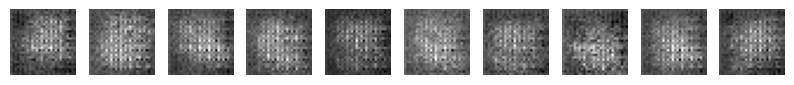

disc_loss 0.0875353515 gen_loss 6.09255362
disc_loss 0.0655706897 gen_loss 6.42881632
disc_loss 0.175311342 gen_loss 7.48568773
disc_loss 0.0664880872 gen_loss 6.87107706
disc_loss 0.150675774 gen_loss 7.15367556
disc_loss 0.0931399316 gen_loss 8.63935757
disc_loss 0.238199443 gen_loss 7.44179153
disc_loss 0.151262894 gen_loss 8.65433502
disc_loss 0.122925378 gen_loss 4.90118074
disc_loss 0.213598639 gen_loss 10.0364342
Epoch 10/2000000
1/1 [==============================] - 0s 48ms/step


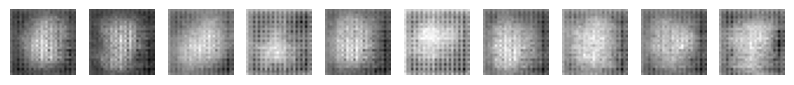

disc_loss 0.219127446 gen_loss 3.37352633
disc_loss 0.134382322 gen_loss 5.52358532


In [ ]:
#@tf.function


def train_step(images, labels):

    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 100])
    generated_images = generator([noise, labels], training=True)



    with tf.GradientTape() as disc_tape:

      real_output = discriminator([images, labels], training=True)
      fake_output = discriminator([generated_images, labels], training=True)

      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    copied_model = tf.keras.models.clone_model(discriminator)

    for i in range(5):
      with tf.GradientTape() as disc_copy_tape:

        real_output = copied_model([images, labels], training=True)
        fake_output = copied_model([generated_images, labels], training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_discriminator = disc_copy_tape.gradient(disc_loss, copied_model.trainable_variables)
      copy_optimizer.apply_gradients(zip(gradients_of_discriminator, copied_model.trainable_variables))



    with tf.GradientTape() as gen_tape:
      generated_images = generator([noise, labels], training=True)
      fake_output = copied_model([generated_images, labels], training=True)
      gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)


def train(generator, discriminator
          , epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(new_images) // batch_size):
            images = new_images[batch * batch_size: (batch+1) * batch_size]
            labels = new_labels[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print_img(generator)

# Train the GAN
EPOCHS = 2000000
BATCH_SIZE = 50
num_unrolling_steps = 5  # Set the desired number of unrolling steps
train(generator, discriminator, EPOCHS, BATCH_SIZE)

In [ ]:
#@tf.function
modi = 1

def train_step(images, labels):
    global modi
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 100])


    clipped = 1-tf.clip_by_value(modi,0,1)
    rot_modi = -1*(clipped*90)
    rot_modi = -.01 if rot_modi==0 else rot_modi

    images_mo = tf.expand_dims(images, axis=-1)
    images_mod = random_rotate_images(images_mo,rot_modi)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    modi = disc_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)


def train(generator, discriminator
          , epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(new_images) // batch_size):
            images = new_images[batch * batch_size: (batch+1) * batch_size]
            labels = new_labels[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print_img(generator)

# Train the GAN
EPOCHS = 2000000
BATCH_SIZE = 50
num_unrolling_steps = 5  # Set the desired number of unrolling steps
train(generator, discriminator, EPOCHS, BATCH_SIZE)